In [1]:
import torchvision.transforms.v2 as v2
from torch import optim
import torch
from torch import nn
import torchvision.models as models


from dlvc.models.resnet18 import ResNet18Dropout
from sklearn.model_selection import ParameterGrid # install scikit-learn

from evaluation import cifar_load, train_model_opt, test_model, save_metrics, plot_metrics

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")



1/16 Training model with hyperparameters: {'dropout_rate': 0.25, 'left_right_mirror': True, 'random_crop': True, 'weight_decay': 0.0001}

Training model:  ResNet18Dropout

TRAIN, EPOCH: 0 
Loss: 2.146782875061035
Accuracy: 0.4436
Class Accuracy: 0.4438504993915558

VALIDATION, EPOCH: 0 
Loss: 2.1218903064727783
Accuracy: 0.5138
Class Accuracy: 0.5134561032056808
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 1 
Loss: 1.2397794723510742
Accuracy: 0.5886
Class Accuracy: 0.5885124266147613

VALIDATION, EPOCH: 1 
Loss: 1.4662437438964844
Accuracy: 0.5644
Class Accuracy: 0.5645917117595672
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 2 
Loss: 1.3189632892608643
Accuracy: 0.6474
Class Accuracy: 0.647150707244873

VALIDATION, EPOCH: 2 
Loss: 1.1746848821640015
Accuracy: 0.5887
Class Accuracy: 0.5881798163056373
Best mean per class accuracy on validation data set is higher. Saving new 

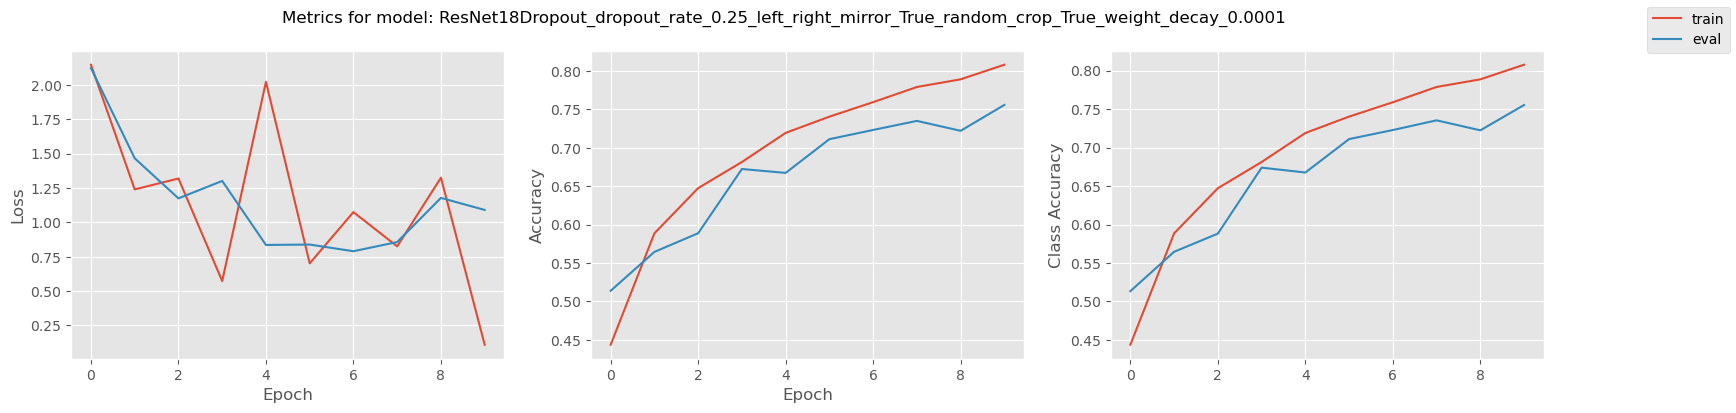

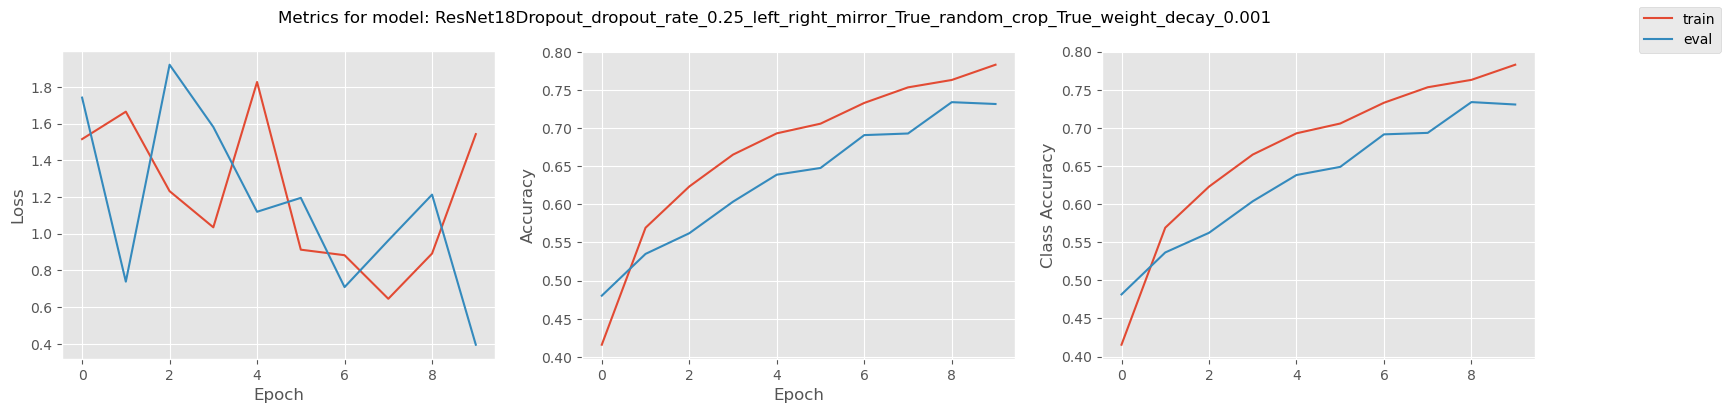

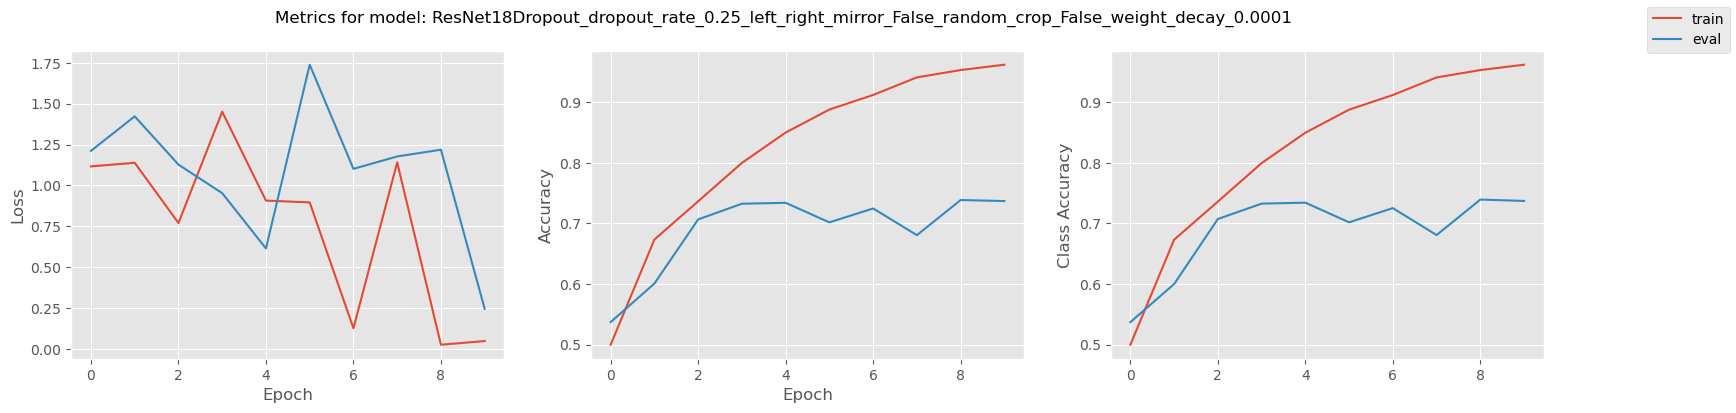

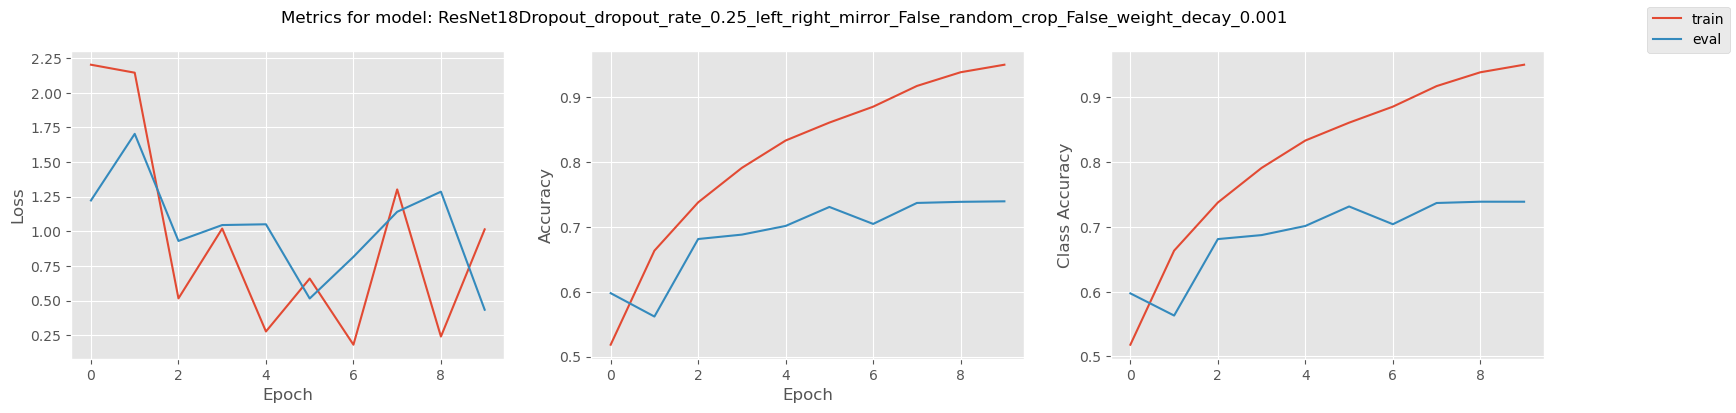

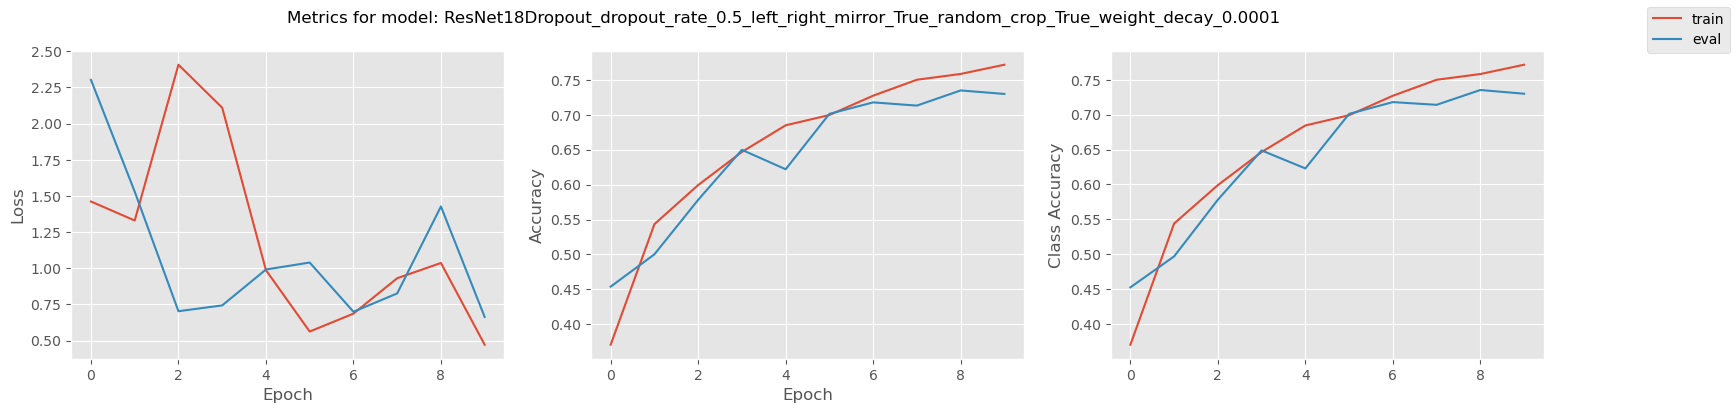

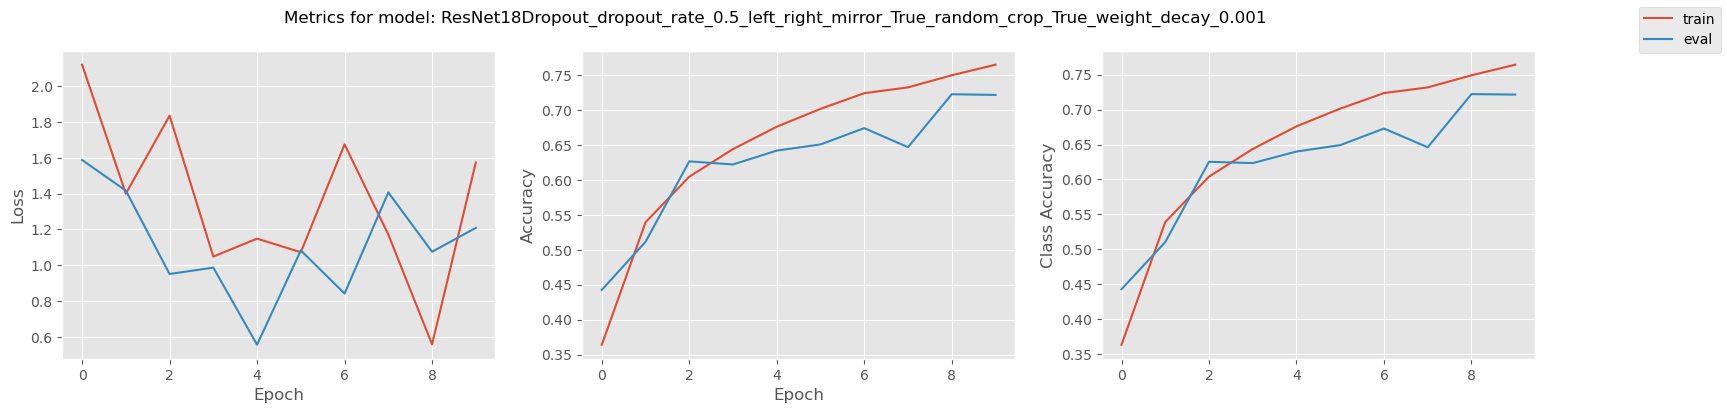

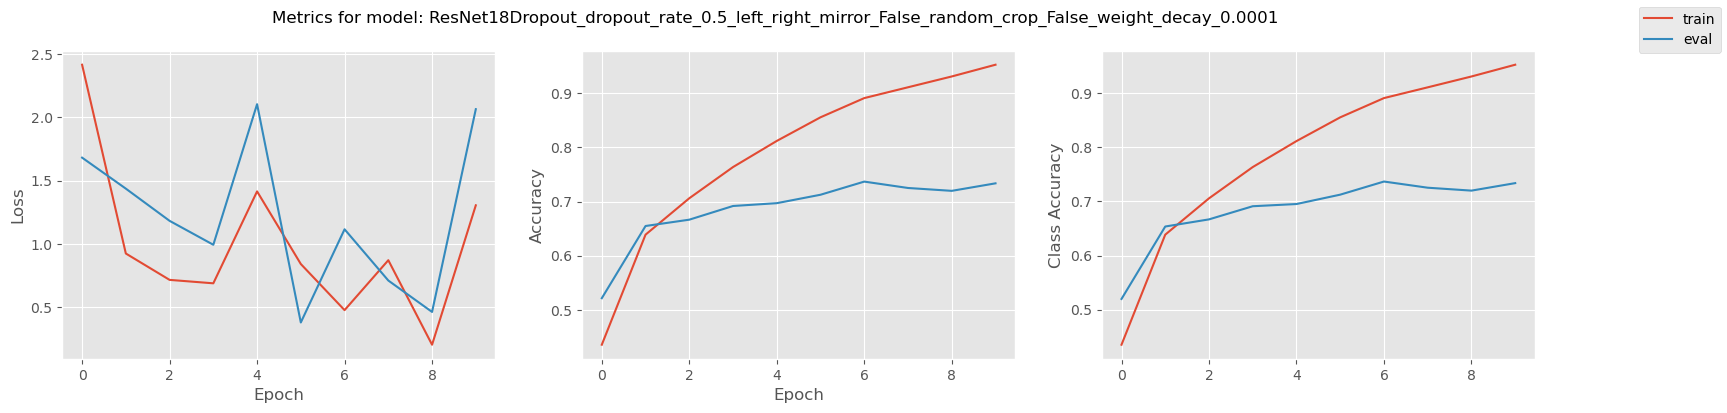

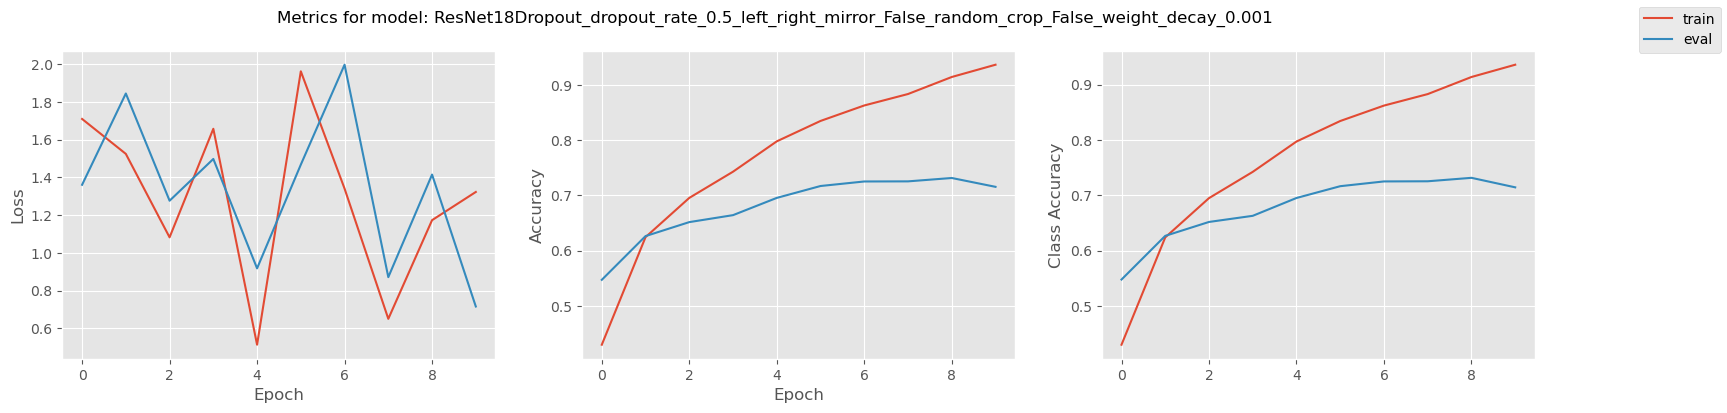

In [3]:
# Perform grid search for hyperparameter optimization
# it takes a while to run, so random crop only and left-right mirror only are passed
param_grid = {
    'random_crop': [True, False],
    'left_right_mirror': [True, False],
    'dropout_rate': [0.25, 0.5],
    'weight_decay': [0.0001, 0.001]
}

best_model_name = None
best_model = None
best_model_accuracy = 0.0
best_parameters = None

for i, params in enumerate(ParameterGrid(param_grid)):
        
    if params['random_crop'] == True and params['left_right_mirror'] == True:
        transform = v2.Compose([
            v2.ToImage(), 
            v2.RandomHorizontalFlip(),
            v2.RandomCrop(32, padding=4),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
        ])
    elif params['random_crop'] == False and params['left_right_mirror'] == False:
        transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
        ])
    else:
        print("\nLeft-right mirror or Random Crop only is passed")
        continue


    train_data_opt, val_data_opt, test_data_opt = cifar_load(transform)

    model = ResNet18Dropout(dropout_rate=params['dropout_rate'])

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=params['weight_decay'])

    print(f'\n\n{i+1}/{len(ParameterGrid(param_grid))} Training model with hyperparameters: {params}')

    name = model.__class__.__name__

    for param in params:
        name += "_"+param + "_" + str(params[param])

    trainer = train_model_opt(model, optimizer, name, train_data_opt, val_data_opt)

    trainer.train()

    save_metrics(trainer, model.__class__.__name__, params)

    model, test_metric = test_model(model, params, test_data_opt)

    plot_metrics(trainer, name)


    if test_metric.accuracy() > best_model_accuracy:
        best_model_accuracy = test_metric.accuracy()
        best_parameters = params
        best_model = model
        best_model_name = name

print("Model:", best_model_name)
print("Best model found with parameters:", best_parameters)
print("Best test accuracy:", best_model_accuracy)